In [374]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import math
import random
from scipy.stats import expon
import time

In [238]:
bronx_all = pd.read_csv('all_bronx_edges.csv')
queens_all = pd.read_csv('all_queens_edges.csv')

In [589]:
bronx_all_graph = nx.from_pandas_edgelist(bronx_all,source='NodeIDFrom',target='NodeIDTo',edge_attr=['SegmentID','persons_injured','pedestrians_injured','volume_count'])

In [590]:
bronx_all_graph[47740][9045677]

{'SegmentID': 78126,
 'pedestrians_injured': 0.0,
 'persons_injured': 2.0,
 'volume_count': 0.0}

In [591]:
bronx_all_graph.nodes[47740]

{}

In [592]:
bronx_all.head()

,Unnamed: 0,SegmentID,NodeIDFrom,NodeIDTo,LCB2010,RCB2010,persons_injured,pedestrians_injured,volume_count
0,0,78126,47740,9045677,3001,2000,2.0,0.0,0.0
1,1,79796,48679,48678,2000,1004,0.0,0.0,0.0
2,2,77356,47288,47822,2000,3006,0.0,0.0,0.0
3,3,73490,45034,45038,1004,1008,0.0,0.0,0.0
4,4,174633,84655,45050,1003,1001,0.0,0.0,0.0


In [593]:
n = bronx_all_graph.number_of_nodes()
m = bronx_all_graph.number_of_edges()
print("Number of nodes:", n)
print("Number of edges:", m)

Number of nodes: 19466
Number of edges: 27163


# Slow Zone Modularity Analysis

In [594]:
node_indicators = pd.read_csv('slow_zone_indicator_csv.csv',dtype=int)
intermediate_dict = node_indicators.set_index('NODEID').to_dict()
node_dict = intermediate_dict['in_slow_zone']

In [595]:
nx.set_node_attributes(bronx_all_graph, node_dict, 'slow_zone_ind')

In [596]:
bronx_all_graph.nodes[47740]

{'slow_zone_ind': 0}

In [597]:
def f_modularity(weight_var, node_ind):
    mod_mtx = nx.modularity_matrix(bronx_all_graph, nodelist = None, weight = weight_var)
    
    node_indicators = list(nx.get_node_attributes(bronx_all_graph, node_ind).values())
    #node_indicators = [0.0 if math.isnan(ind) else ind for ind in node_indicators]
    n_slow_zone_nodes = sum(node_indicators)
    percent_slow_zone_nodes = n_slow_zone_nodes/n*100
    
    k_delta = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if node_indicators[i] == node_indicators[j]:
                k_delta[i][j] = 1
    
    slow_zone_mod = 1/(2*m)*np.matmul(mod_mtx, k_delta).sum()
    return(n_slow_zone_nodes, percent_slow_zone_nodes, slow_zone_mod)

In [598]:
slow_zone_modularity = f_modularity('persons_injured', 'slow_zone_ind')

In [599]:
print("Number of nodes in slow zones:", slow_zone_modularity[0])
print("Percentage of nodes in slow zones:", slow_zone_modularity[1], "%")
print("Modularity:", slow_zone_modularity[2])

Number of nodes in slow zones: 808
Percentage of nodes in slow zones: 4.150827083119285 %
Modularity: 7.089795051195588e-13


### Expand to include nodes within proximity of slow zones

In [435]:
streets = gpd.read_file("/Users/rgalowich/Desktop/PC - Shared/CEE 345/lion_streets")
nodes = gpd.read_file("/Users/rgalowich/Desktop/PC - Shared/CEE 345/lion_projected_nodes")
slow_zones = gpd.read_file("/Users/rgalowich/Dropbox (MIT)/Stanford/18-19/Spring/CEE 345/Final Project/VZV_Neighborhood Slow Zones")

In [436]:
bronx_streets = streets.loc[streets['LBoro'] == 2]

In [600]:
nodes = nodes.to_crs({'init':'epsg:6347'})
slow_zones = slow_zones.to_crs({'init':'epsg:6347'})
bronx_streets = bronx_streets.to_crs({'init':'epsg:6347'})

avg_zone_width = slow_zones.geometry.length.mean()
avg_segment_length = bronx_streets.geometry.length.mean()
print("Average slow zone width:", avg_zone_width)
print("Average street segment length:", avg_segment_length)

Average slow zone width: 3345.0372814368206
Average street segment length: 78.16468484171017


In [605]:
def slow_zone_nodes(nodes):
    distances = slow_zones.geometry.apply(lambda zone: zone.distance(nodes))
    if distances.min() < avg_segment_length:
        return 1
    else:
        return 0

In [606]:
ind_list = nodes.geometry.apply(slow_zone_nodes)
proximity_ind_dict = {}
n_ind = len(ind_list)

for idx in range(n_ind):
    temp_key = nodes['NODEID'].loc[idx]
    temp_val = ind_list[idx]
    proximity_ind_dict.update({temp_key: temp_val})

nx.set_node_attributes(bronx_all_graph,proximity_ind_dict,'slow_zone_proximity_ind')

In [607]:
proximity_modularity = f_modularity('persons_injured', 'slow_zone_proximity_ind')

In [608]:
print("Number of nodes in close proximity to slow zones:", proximity_modularity[0])
print("Percentage of nodes in close proximity to slow zones:", proximity_modularity[1], "%")
print("Modularity:", proximity_modularity[2])

Number of nodes in close proximity to slow zones: 1276
Percentage of nodes in close proximity to slow zones: 6.555019007500257 %
Modularity: 4.883808754577893e-13


### Group by total injury degree -- intersections with large number of injuries concentrated in geographic area?

In [494]:
all_node_persons_injured = list(bronx_all_graph.degree(weight='persons_injured'))
all_node_ped_injured = list(bronx_all_graph.degree(weight='pedestrians_injured'))

all_persons_degrees = []
all_ped_degrees = []
all_list_len = len(bc_centrality)

for idx in range(all_list_len):
    all_persons_degrees.append(all_node_persons_injured[idx][1])
    all_ped_degrees.append(all_node_ped_injured[idx][1])

In [512]:
injury_df = pd.DataFrame(all_node_persons_injured, columns = ['node_id','persons_injured']).sort_values('persons_injured',ascending=False)
injury_df.head()

injury_thresh = injury_df.quantile(0.95)[1]
print(injury_thresh)

injury_df['injury_indicator'] = 0
injury_df.loc[injury_df['persons_injured'] > injury_thresh, 'injury_indicator'] = 1

4.0


In [609]:
injury_df.head()

,node_id,persons_injured,injury_indicator
10265,97962,42.0,1
4756,44699,42.0,1
1910,48820,32.0,1
7997,49293,32.0,1
6036,47879,31.0,1


In [615]:
intermediate_injury_dict = injury_df.set_index('node_id').to_dict()
node_injury_dict = intermediate_injury_dict['injury_indicator']
nx.set_node_attributes(bronx_all_graph, node_injury_dict, 'injury_ind')

In [616]:
bronx_all_graph.nodes[47740]

{'injury_ind': 0, 'slow_zone_ind': 0, 'slow_zone_proximity_ind': 0}

In [617]:
injury_modularity = f_modularity('persons_injured', 'injury_ind')

Number of nodes at or above 95th percentile: 1276
Modularity: 4.883808754577893e-13


In [618]:
print("Number of nodes at or above 95th percentile:", injury_modularity[0])
print("Modularity:", injury_modularity[2])

Number of nodes at or above 95th percentile: 707
Modularity: 7.024534880479014e-13


# Betweenness Centralities

In [73]:
bronx_counts = pd.read_csv('bronx_traffic_edges.csv')
queens_counts = pd.read_csv('queens_traffic_edges.csv')

In [74]:
bronx_counts.head()

,Unnamed: 0,SegmentID,NodeIDFrom,NodeIDTo,LCB2010,RCB2010,persons_injured,pedestrians_injured,volume_count
0,188,81384,49666,54110,1025,1026,0.0,0.0,9021.0
1,346,88039,53649,53715,4006,1004,0.0,0.0,3027.0
2,422,69588,42728,42732,1018,1007,0.0,0.0,4951.0
3,494,88020,53640,53641,2000,1001,0.0,0.0,8288.0
4,502,88031,53645,53653,1003,3000,4.0,1.0,4763.0


In [225]:
bronx_nonzero_graph = nx.from_pandas_edgelist(bronx_counts,source='NodeIDFrom',target='NodeIDTo',edge_attr=['SegmentID','persons_injured','pedestrians_injured','volume_count'])

In [228]:
node_persons_injured = list(bronx_nonzero_graph.degree(weight='persons_injured'))
node_ped_injured = list(bronx_nonzero_graph.degree(weight='pedestrians_injured'))
node_flow = list(bronx_nonzero_graph.degree(weight='volume_count'))

persons_degrees = []
ped_degrees = []
flow_degrees = []
list_len = len(node_persons_injured)

for idx in range(list_len):
    persons_degrees.append(node_persons_injured[idx][1])
    ped_degrees.append(node_ped_injured[idx][1])
    flow_degrees.append(node_flow[idx][1])

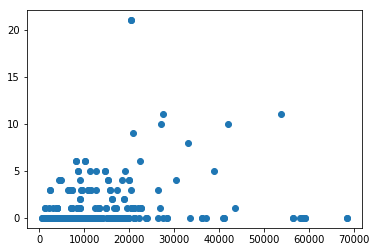

In [229]:
plt.scatter(flow_degrees, persons_degrees)

##### Find outlier

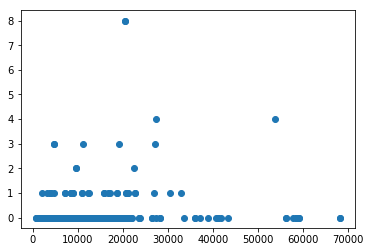

In [230]:
plt.scatter(flow_degrees, ped_degrees)

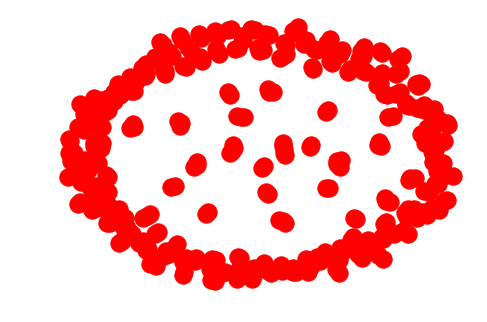

In [211]:
nx.draw(bronx_nonzero_graph)

In [372]:
n_components = nx.number_connected_components(bronx_all_graph)
print("Number of connected components:", n_components)

n_nonzero_components = nx.number_connected_components(bronx_nonzero_graph)
print("Number of connected components in graph subset:", n_nonzero_components)

Number of connected components: 39
Number of connected components in graph subset: 157


### Randomly assign degrees to be within range of adjacent nodes' traffic volume degrees 

In [185]:
node_list = list(bronx_all_graph.nodes())
neighbor_dict = {}

bronx_all_adj = bronx_all_graph.adj
range_dict = {}
temp_list = []

for node_idx in range(n):
    temp_node = node_list[node_idx]
    node_info = bronx_all_graph.adj[temp_node]
    #print(node_info)
    n_keys = len(node_info)
    #print(n_keys)
    for key_idx in range(n_keys):
        #print(key_idx)
        temp_key = list(node_info.keys())[key_idx]
        temp_list.append(node_info[temp_key]['volume_count'])
    max_count = max(temp_list)
    min_count = min(temp_list)
    range_dict.update({temp_node:{'max':max_count,'min':min_count}})
    temp_list = []

In [195]:
node_len = len(list(bronx_nonzero_graph.nodes()))
print(node_len)

356


In [189]:
nonzero_cases = {}

for node_idx in range(n):
    node_key = node_list[node_idx]
    if range_dict[node_key]['max'] > 0:
        nonzero_cases.update({node_key: range_dict[node_key]})

In [191]:
print(len(nonzero_cases))

325


### Randomly assign counts to larger network based on distribution of existing values

In [223]:
sorted_flow_degrees = sorted(flow_degrees_only)

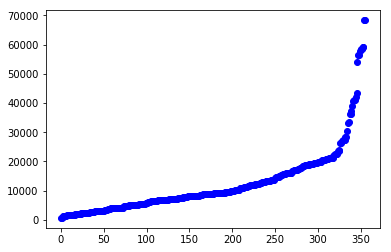

In [224]:
plt.plot(sorted_flow_degrees,'bo')

(array([67., 74., 68., 42., 28., 34., 13.,  6.,  3.,  2.,  3.,  4.,  2.,
         0.,  0.,  1.,  3.,  4.,  0.,  2.]),
 array([  656. ,  4039.7,  7423.4, 10807.1, 14190.8, 17574.5, 20958.2,
        24341.9, 27725.6, 31109.3, 34493. , 37876.7, 41260.4, 44644.1,
        48027.8, 51411.5, 54795.2, 58178.9, 61562.6, 64946.3, 68330. ]),
 <a list of 20 Patch objects>)

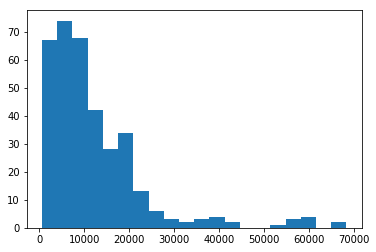

In [275]:
plt.hist(flow_degrees, bins=20)

In [310]:
# Exponential distribution function
flow_mean = np.mean(flow_degrees)
rate_est = 1/flow_mean
scale_est = 1./exp_rate

In [313]:
exp_scale = expon.fit(flow_degrees)[1]
exp_rate = 1./exp_scale

In [314]:
print("Estimated parameter:", rate_est)
print("Fit parameter:", exp_rate)

print("Estimated scale:", scale_est)
print("Fit scale:", exp_scale)

Estimated parameter: 8.092454013948117e-05
Fit parameter: 8.589421662705999e-05
Estimated scale: 12357.191011235956
Fit scale: 11642.227373023872


In [620]:
n_iter = 1000
edge_list = list(bronx_all_graph.edges())
rand_flow_dict = {}

for edge_idx in range(m):
    edge_key = edge_list[edge_idx]
    edge_volumes = nx.get_edge_attributes(bronx_all_graph,'volume_count')
    if edge_volumes[edge_key] == 0:
        rand_flows = np.random.exponential(exp_scale, n_iter)
        rand_edge_val = rand_flows.mean()
        rand_flow_dict.update({edge_key: rand_edge_val})
        rand_flows = []
    else:
        data_edge_val = edge_volumes[edge_key]
        rand_flow_dict.update({edge_key: data_edge_val})
    #attribute_name = "generated_counts_" + str(iter_idx)
    #nx.set_edge_attributes(bronx_all_graph, rand_flow_dict[iter_key], name = attribute_name)

In [621]:
nx.set_edge_attributes(bronx_all_graph, rand_flow_dict, name = 'generated_counts')

In [623]:
bronx_all_graph[47740][9045677]

{'SegmentID': 78126,
 'generated_counts': 11208.80563737288,
 'pedestrians_injured': 0.0,
 'persons_injured': 2.0,
 'volume_count': 0.0}

In [624]:
bc_centrality = nx.betweenness_centrality(bronx_all_graph, weight='generated_counts')
bc_centrality_list = list(bc_centrality.values())

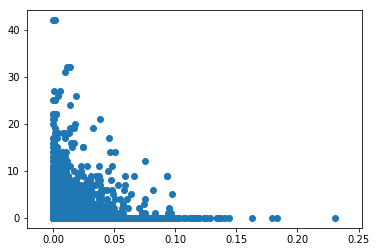

In [625]:
plt.scatter(bc_centrality_list, all_persons_degrees)

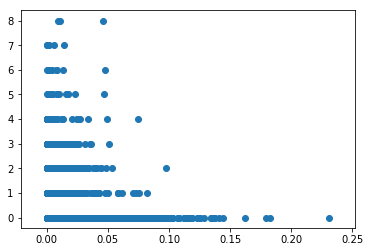

In [626]:
plt.scatter(bc_centrality_list, all_ped_degrees)

# Write node .csv

In [644]:
node_property_dict = {}

for node_idx in range(n):
    node_key = node_list[node_idx]
    node_slow_zone_indicator = node_dict[node_key]
    node_slow_zone_proximity_indicator = proximity_ind_dict[node_key]
    node_injury_percentile_indicator = node_injury_dict[node_key]
    node_persons_injured_degree = all_node_persons_injured[node_idx][1]
    node_ped_injured_degree = all_node_ped_injured[node_idx][1]
    node_bc_centrality = bc_centrality[node_key]
    node_property_dict.update({node_key: {'slow_zone_indicator': node_slow_zone_indicator, 
                                          'slow_zone_proximity_indicator': node_slow_zone_proximity_indicator,
                                          'injury_percentile_indicator': node_injury_percentile_indicator,
                                          'persons_injured': node_persons_injured_degree, 
                                          'ped_injured': node_ped_injured_degree, 
                                          'bc_centrality': node_bc_centrality}
                              })

In [649]:
node_csv = pd.DataFrame.from_dict(node_property_dict, orient='index')

In [650]:
node_csv.head()

,slow_zone_indicator,slow_zone_proximity_indicator,injury_percentile_indicator,persons_injured,ped_injured,bc_centrality
42354,0,0,0,0.0,0.0,0.000000
42390,0,0,0,0.0,0.0,0.000000
42391,0,0,0,0.0,0.0,0.000000
42392,0,0,0,0.0,0.0,0.000102
42417,0,0,0,0.0,0.0,0.000216


In [651]:
node_csv.to_csv("node_csv_for_regression.csv")

# ARCHIVE

### Find centralities for original graph -- subset to nodes with non-zero traffic volume degree

In [129]:
flow_centrality_all = nx.betweenness_centrality(bronx_all_graph,weight='volume_count')
flow_centrality_subset = dict((k, flow_centrality_all[k]) for k in flow_centrality_keys)

In [140]:
subset_vals = flow_centrality_subset.values()

(0, 1)

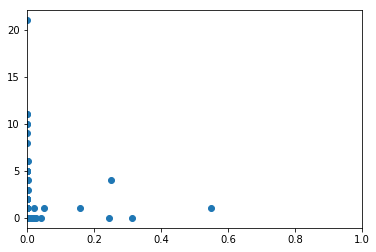

In [142]:
plt.scatter(subset_vals,crash_degrees_only)
plt.xlim(0,1)

### Create random network topology with same number of nodes

In [206]:
to_node = random.sample(range(0, node_len), node_len)
from_node = random.sample(range(0, node_len), node_len)

rand_edge = pd.DataFrame()
rand_edge['to_node'] = to_node
rand_edge['from_node'] = from_node

#add clause to avoid self-loops

rand_edge['persons_injured'] = bronx_counts['persons_injured']
rand_edge['volume_count'] = bronx_counts['volume_count']

In [207]:
random_graph = nx.from_pandas_edgelist(rand_edge,source='from_node',target='to_node',edge_attr=['persons_injured','volume_count'])

In [209]:
r_crash_degrees = list(random_graph.degree(weight='persons_injured'))
r_flow_betweenness = nx.betweenness_centrality(random_graph,weight='volume_count').values()

r_degrees_only = []

for idx in range(node_len):
    r_degrees_only.append(r_crash_degrees[idx][1])

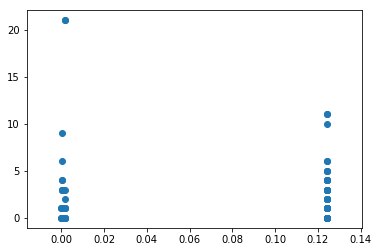

In [210]:
plt.scatter(r_flow_betweenness,r_degrees_only)